In [1]:
import torch as t 
import torchvision
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pylab as plt
from torch.nn.utils import clip_grad_value_
%matplotlib inline
import pickle
from torchvision import datasets, transforms
import tqdm
import os
import sys
sys.path.append('../src/')

In [16]:
import importlib 
import linear_var_hypernet as linear_var_hypernet
import var_net as var_net
import mnist_utils as utils
importlib.reload(utils)
importlib.reload(var_net)
importlib.reload(linear_var_hypernet)



<module 'linear_var_hypernet' from '../src/linear_var_hypernet.py'>

In [10]:
device = 'cuda' # cuda or cpu
device = t.device(device)
if device == 'cuda':
    t.backends.cudnn.deterministic = True
    t.backends.cudnn.benchmark = False

In [6]:
batch_size = 256
init_log_sigma = -3.0 # логарифм дисперсии вариационного распределения при инициализации
prior_sigma = .1 # априорная дисперсия
epoch_num = 25 #количество эпох
lamb = [0.01, 0.1, 1.0,  10.0, 100.0]
lamb = [t.tensor(l) for l in lamb]
hidden_num = 50 # количество нейронов на скрытом слое
acc_delete = [] 
start_num = 5
path_to_save = 'saved_mnist'
lambda_sample_num = 5
lambda_encode = t.log 

if not os.path.exists(path_to_save):
    os.mkdir(path_to_save)

In [7]:
# загрузка данных
train_data = torchvision.datasets.MNIST('./files/', train=True, download=True,
                             transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                                  torchvision.transforms.Lambda(lambda x: x.view(-1))
                              ]))

test_data = torchvision.datasets.MNIST('./files/', train=False, download=True,
                             transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                                  torchvision.transforms.Lambda(lambda x: x.view(-1))
                              ]))


train_loader = t.utils.data.DataLoader(train_data, batch_size=batch_size, pin_memory=True )
test_loader = t.utils.data.DataLoader(test_data, batch_size=batch_size)





In [17]:
t.manual_seed(0)

for start in range(start_num):                    
        net = var_net.VarNet(linear_var_hypernet.VarLayerLinearAppr(784,  hidden_num, prior_sigma=prior_sigma, init_log_sigma=init_log_sigma),
                     linear_var_hypernet.VarLayerLinearAppr(hidden_num, 10,  prior_sigma=prior_sigma, act=lambda x:x, init_log_sigma=init_log_sigma))

        net = net.to(device)
        optim = t.optim.Adam(net.parameters(), lr=5e-4)
        loss_fn = nn.CrossEntropyLoss().to(device)            
        for e in range(epoch_num):
            label = 'epoch {}: '.format(e)                
            utils.train_batches_hypernet(train_loader,  len(train_data), lambda_sample_num,
                  lambda_encode, net, device, loss_fn, optim, label, rep=True)
            if e%5 == 0:
                print (utils.test_acc_hyper(net, device, test_loader, lambda_encode, lamb))
        t.save(net.state_dict(), os.path.join(path_to_save, 'rep_linear_start_{}.cpk'.format(start)))

epoch 1: 9.181097:   1%|          | 2/235 [00:00<00:17, 13.52it/s]

{tensor(0.0100): 0.7915, tensor(0.1000): 0.7663, tensor(1.): 0.478, tensor(10.): 0.8247, tensor(100.): 0.8446}


epoch 6: 0.64422023:   1%|          | 2/235 [00:00<00:19, 12.06it/s]

{tensor(0.0100): 0.9233, tensor(0.1000): 0.9282, tensor(1.): 0.9135, tensor(10.): 0.8938, tensor(100.): 0.8778}


epoch 11: 0.74031484:   1%|          | 2/235 [00:00<00:18, 12.52it/s]

{tensor(0.0100): 0.9468, tensor(0.1000): 0.9479, tensor(1.): 0.9384, tensor(10.): 0.902, tensor(100.): 0.8738}


epoch 16: 0.58751506:   1%|          | 2/235 [00:00<00:21, 10.84it/s]

{tensor(0.0100): 0.9561, tensor(0.1000): 0.956, tensor(1.): 0.9461, tensor(10.): 0.9097, tensor(100.): 0.8474}


epoch 21: 0.42669374:   1%|          | 2/235 [00:00<00:18, 12.36it/s]

{tensor(0.0100): 0.9598, tensor(0.1000): 0.962, tensor(1.): 0.9525, tensor(10.): 0.9106, tensor(100.): 0.8427}


epoch 1: 10.113204:   1%|          | 2/235 [00:00<00:17, 13.09it/s]

{tensor(0.0100): 0.7934, tensor(0.1000): 0.7512, tensor(1.): 0.4209, tensor(10.): 0.8234, tensor(100.): 0.8398}


epoch 6: 1.7932684:   1%|          | 2/235 [00:00<00:21, 10.97it/s]

{tensor(0.0100): 0.9138, tensor(0.1000): 0.9173, tensor(1.): 0.9083, tensor(10.): 0.8864, tensor(100.): 0.894}


epoch 11: 1.2458459:   0%|          | 0/235 [00:00<?, ?it/s]

{tensor(0.0100): 0.942, tensor(0.1000): 0.9405, tensor(1.): 0.9323, tensor(10.): 0.9116, tensor(100.): 0.8691}


epoch 16: 0.62039655:   1%|          | 2/235 [00:00<00:20, 11.30it/s]

{tensor(0.0100): 0.9544, tensor(0.1000): 0.9534, tensor(1.): 0.9429, tensor(10.): 0.9114, tensor(100.): 0.8515}


epoch 21: 0.46646422:   1%|          | 2/235 [00:00<00:18, 12.57it/s]

{tensor(0.0100): 0.9442, tensor(0.1000): 0.9541, tensor(1.): 0.9502, tensor(10.): 0.9189, tensor(100.): 0.8376}


epoch 1: 12.702103:   1%|          | 2/235 [00:00<00:15, 14.87it/s]

{tensor(0.0100): 0.6277, tensor(0.1000): 0.6105, tensor(1.): 0.4079, tensor(10.): 0.8172, tensor(100.): 0.8445}


epoch 6: 1.8878071:   1%|          | 2/235 [00:00<00:21, 11.07it/s]

{tensor(0.0100): 0.9195, tensor(0.1000): 0.9193, tensor(1.): 0.899, tensor(10.): 0.8877, tensor(100.): 0.8447}


epoch 11: 2.1555772:   1%|          | 2/235 [00:00<00:20, 11.34it/s]

{tensor(0.0100): 0.9405, tensor(0.1000): 0.9403, tensor(1.): 0.9312, tensor(10.): 0.9039, tensor(100.): 0.8606}


epoch 16: 0.7294727:   1%|          | 2/235 [00:00<00:13, 16.77it/s] 

{tensor(0.0100): 0.9517, tensor(0.1000): 0.9528, tensor(1.): 0.9447, tensor(10.): 0.9052, tensor(100.): 0.7615}


epoch 21: 0.61307395:   0%|          | 0/235 [00:00<?, ?it/s]

{tensor(0.0100): 0.9523, tensor(0.1000): 0.9562, tensor(1.): 0.9501, tensor(10.): 0.9117, tensor(100.): 0.8254}


epoch 1: 11.503836:   0%|          | 1/235 [00:00<00:27,  8.40it/s]

{tensor(0.0100): 0.7838, tensor(0.1000): 0.7415, tensor(1.): 0.4298, tensor(10.): 0.7676, tensor(100.): 0.7748}


epoch 6: 1.0608393:   0%|          | 0/235 [00:00<?, ?it/s]

{tensor(0.0100): 0.9223, tensor(0.1000): 0.9231, tensor(1.): 0.907, tensor(10.): 0.8951, tensor(100.): 0.8753}


epoch 11: 1.4297354:   1%|          | 2/235 [00:00<00:20, 11.35it/s]

{tensor(0.0100): 0.9428, tensor(0.1000): 0.9453, tensor(1.): 0.9367, tensor(10.): 0.9021, tensor(100.): 0.8308}


epoch 16: 0.571956:   1%|          | 2/235 [00:00<00:22, 10.19it/s]

{tensor(0.0100): 0.9509, tensor(0.1000): 0.9536, tensor(1.): 0.947, tensor(10.): 0.9156, tensor(100.): 0.8165}


epoch 21: 0.46946073:   1%|          | 2/235 [00:00<00:19, 12.16it/s]

{tensor(0.0100): 0.9556, tensor(0.1000): 0.9596, tensor(1.): 0.9539, tensor(10.): 0.9128, tensor(100.): 0.7707}


epoch 1: 21.751534:   1%|          | 2/235 [00:00<00:21, 11.06it/s]

{tensor(0.0100): 0.796, tensor(0.1000): 0.7552, tensor(1.): 0.4666, tensor(10.): 0.7773, tensor(100.): 0.8014}


epoch 6: 3.7512112:   1%|          | 2/235 [00:00<00:18, 12.90it/s]

{tensor(0.0100): 0.9239, tensor(0.1000): 0.9255, tensor(1.): 0.9139, tensor(10.): 0.8943, tensor(100.): 0.8895}


epoch 11: 1.3670237:   1%|          | 2/235 [00:00<00:22, 10.48it/s]

{tensor(0.0100): 0.9462, tensor(0.1000): 0.9461, tensor(1.): 0.9342, tensor(10.): 0.8981, tensor(100.): 0.8643}


epoch 16: 0.7672189:   1%|          | 2/235 [00:00<00:20, 11.35it/s]

{tensor(0.0100): 0.9533, tensor(0.1000): 0.954, tensor(1.): 0.9449, tensor(10.): 0.9076, tensor(100.): 0.8011}


epoch 21: 0.4518984:   0%|          | 0/235 [00:00<?, ?it/s]

{tensor(0.0100): 0.9582, tensor(0.1000): 0.9572, tensor(1.): 0.95, tensor(10.): 0.9168, tensor(100.): 0.7765}


epoch 24: 0.3886636: 100%|██████████| 235/235 [00:21<00:00, 10.90it/s] 


In [18]:
net = var_net.VarNet(var_net.VarLayer(784,  hidden_num, 
                                            prior_sigma = prior_sigma, init_log_sigma=init_log_sigma), 
                                 var_net.VarLayer(hidden_num, 10, prior_sigma=prior_sigma,  init_log_sigma=init_log_sigma,
                                          act=lambda x:x)).to(device)    
hnet = var_net.VarNet(linear_var_hypernet.VarLayerLinearAppr(784,  hidden_num, prior_sigma=prior_sigma, init_log_sigma=init_log_sigma),
                     linear_var_hypernet.VarLayerLinearAppr(hidden_num, 10,  prior_sigma=prior_sigma, act=lambda x:x, init_log_sigma=init_log_sigma))

hnet = hnet.to(device)
net = net.to(device)
lam_results = {}
for lam in lamb:
    lam_results[lam] = []
    for s in range(start_num):        
        print (lam, s)
        hnet.load_state_dict(t.load(os.path.join(path_to_save, 'rep_linear_start_{}.cpk'.format(s))))        
        utils.net_copy(hnet, net, lambda_encode(t.ones(1).to(device)[0]*lam))
        lam_results[lam].append(utils.delete_10(net, device, lambda:utils.test_acc_net(net, device, test_loader)))
lam_results = {float(k):lam_results[k] for k in lam_results}
import json
with open(os.path.join(path_to_save, 'results_rep_linear.json'),'w') as out:
    out.write(json.dumps(lam_results))  

../src/var_net.py:9: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  t.nn.init.xavier_uniform(self.mean)


tensor(0.0100) 0
tensor(0.0100) 1
tensor(0.0100) 2
tensor(0.0100) 3
tensor(0.0100) 4
tensor(0.1000) 0
tensor(0.1000) 1
tensor(0.1000) 2
tensor(0.1000) 3
tensor(0.1000) 4
tensor(1.) 0
tensor(1.) 1
tensor(1.) 2
tensor(1.) 3
tensor(1.) 4
tensor(10.) 0
tensor(10.) 1
tensor(10.) 2
tensor(10.) 3
tensor(10.) 4
tensor(100.) 0
tensor(100.) 1
tensor(100.) 2
tensor(100.) 3
tensor(100.) 4


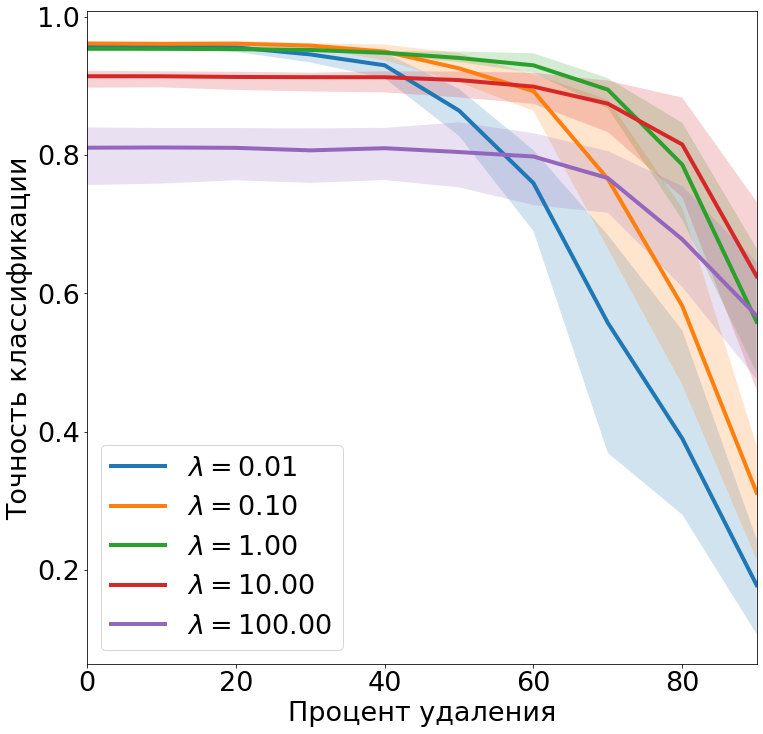

In [19]:
proc = [0,10,20,30,40,50,60,70,80,90]
plt.rcParams['figure.figsize'] = 12, 12
plt.rcParams.update({'font.size': 27})
plt.rc('lines', linewidth=4)
    
    
for lam in lamb:
    lam = float(lam)
    lam_str = "{:10.2f}".format(lam)

    plt.fill_between(proc, np.min(lam_results[lam], 0), np.max(lam_results[lam], 0), alpha=0.2)
    plt.plot(proc, np.mean(lam_results[lam], 0), label='$\lambda={}$'.format(lam_str))
plt.ylabel('Точность классификации', fontsize = 27)
plt.xlabel('Процент удаления', fontsize = 27)
plt.tick_params(axis='both', which='major', labelsize=27)
plt.legend(loc='lower left')
plt.autoscale(enable=True, axis='x', tight=True)
plt.savefig('Linear_rep')
#plt.show()
